In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from graph import Graph
from helpers import get_hermitian_adjacency_matrix, get_adjacency_matrix, get_degree_matrix, get_laplacian_matrix

In [23]:
font = {'size'   : 20}

plt.rc('font', **font)

In [24]:
def compute_bounds_RST(eigenvalues, rayleigh_quotients, q):
    """eigenvalues is an array of the eigenvalues of the matrix
    expected_eigenvalues is an array of the eigenvalues of the expected matrix
    q is a list of indices. If p = len(q), then we return the lower bound for A_1, A_2, ... A_p.
    For example, if q = [2,5] then we return the lower bounds for A_1 and A_2 where A_1 corresponds to the first two rows of alpha and A_2 corresponds to the next three rows of alpha."""
    A_1_lower_bound =(q[0]*eigenvalues[q[0]] - np.sum(rayleigh_quotients[0:q[0]]))/(eigenvalues[q[0]] - eigenvalues[0])
    lower_bounds = [A_1_lower_bound]
    for i in range(1,len(q)):
        width = q[i] - q[i-1]
        lower_bound = (width*eigenvalues[q[i]] - np.sum(rayleigh_quotients[q[i-1]:q[i]]) - eigenvalues[q[i]]*(q[i-1] - np.sum(lower_bounds)))/(eigenvalues[q[i]] - eigenvalues[q[i-1]])
        lower_bounds.append(lower_bound)
    return lower_bounds

In [25]:

def k_means_indicator_vectors(eigenvectors, K):
    assert eigenvectors.shape[1] >= K, 'Number of eigenvectors should be greater than or equal to K'
    kmeans = KMeans(n_clusters=K, random_state=0).fit(eigenvectors)
    indicator_vectors = np.zeros((eigenvectors.shape[0], K))
    for i in range(K):
        indicator_vectors[:,i] = kmeans.labels_ == i
    return indicator_vectors

def degree_correction(vectors, D_sqrt):
    vectors_corrected = vectors.copy()
    for i in range(vectors.shape[1]):
        vectors_corrected[:,i] = D_sqrt @ vectors[:,i]
        vectors_corrected[:,i] = vectors_corrected[:,i] / np.linalg.norm(vectors_corrected[:,i])
    return vectors_corrected

In [26]:
def compute_k_way_estimate(normalised_L, indicator_vectors, K):
    k_way_possibilities = []
    assert indicator_vectors.shape[1] == K, 'Indicator vectors should have K columns'
    for i in range(K):
        indicator = indicator_vectors[:, i]
        val = indicator.T @ normalised_L @ indicator
        k_way_possibilities.append(val)
    return max(k_way_possibilities)


def compute_rayleigh_quotients(normalised_L, indicator_vectors, K):
    rayleigh_quotients = []
    assert indicator_vectors.shape[1] == K, 'Indicator vectors should have K columns'
    for i in range(K):
        indicator = indicator_vectors[:, i]
        val = (indicator.T @ normalised_L @ indicator) / (indicator.T @ indicator)
        rayleigh_quotients.append(val)
    return rayleigh_quotients


def compute_all_bounds(G: Graph, K: int, q: list, true_clusters: list):
    D = get_degree_matrix(G)
    D_sqrt = np.sqrt(D)
    normalized_L = get_laplacian_matrix(G, normalized=True)

    # compute first K eigenvectors of the normalized Laplacian
    normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_L)
    idx = normalized_L_eigenvalues.argsort()
    normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
    normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

    indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
    indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
    beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
    combined_indicator_vectors = indicator_vectors @ beta_K_by_K
    for i in range(K):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
            combined_indicator_vectors[:, i])
        for j in range(i):
            combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                        combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                             i]) * combined_indicator_vectors[:, j]

    rayleigh_quotients = compute_rayleigh_quotients(normalized_L, combined_indicator_vectors, K)
    rayleigh_quotients = np.sort(rayleigh_quotients)
    ST_standard = K * max(rayleigh_quotients) / normalized_L_eigenvalues[K]

    # create indicator vectors from true clusters
    true_indicator_vectors = np.zeros((len(G.vertices), K))
    for i in range(K):
        true_indicator_vectors[true_clusters[i], i] = 1
    true_indicator_vectors = degree_correction(true_indicator_vectors, D_sqrt)
    alpha = true_indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
    true_value = K - np.sum(np.sum(alpha ** 2, axis=1), axis=0)

    recursive_ST = K - np.sum(compute_bounds_RST(normalized_L_eigenvalues, rayleigh_quotients, q))
    general_ST = K - np.sum(compute_bounds_RST(normalized_L_eigenvalues, rayleigh_quotients, [K]))

    return {'Recursive ST': recursive_ST,
            'General ST': general_ST,
            'ST Standard': ST_standard,
            'True Value': true_value} 

In [27]:
# construct a graph from the data points using a threshold
def construct_graph(X, threshold):
    N = X.shape[0]
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                dist = np.linalg.norm(X[i] - X[j])
                if dist < threshold:
                    A[i, j] = 1
    return A

# TESTING ERRORS FOR GEOMETRIC GRAPHS

In [28]:
rst_bounds = {}
st_bounds = {}
k_way_bounds = {}
true_values = {}
n_clusters = 4
sample_size = 10
for n in np.arange(100,1000,100):
    rst_bounds_temp = []
    st_bounds_temp = []
    k_way_bounds_temp = []
    true_values_temp = []
    print(f"commencing computation for n = {n}")
    for p in range(sample_size):
    
        X1 = np.random.multivariate_normal(mean = [0,0], cov = [[1,0],[0,1]], size = n)
        X2 = np.random.multivariate_normal(mean = [0,5], cov = [[1,0],[0,1]], size = n)
        X3 = np.random.multivariate_normal(mean = [8,0], cov = [[1,0],[0,1]], size = n)
        X4 = np.random.multivariate_normal(mean = [8,5], cov = [[1,0],[0,1]], size = n)
        X = np.concatenate((X1, X2, X3, X4))
        
        A = construct_graph(X, 4)
        degrees = np.sum(A, axis = 1)
        D_sqrt = np.diag(np.sqrt(degrees))
        D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
        norm_L = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
        eigvals, eigvecs = np.linalg.eigh(norm_L)
        idx = np.argsort(eigvals)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(eigvecs[:, 0:n_clusters])
        
        #compute exact indicator vectors (from clusters from distributions not k means)
        exact_indicator_vectors = np.zeros((eigvecs.shape[0], n_clusters))
        for i in range(n_clusters):
            exact_indicator_vectors[i*n:(i+1)*n,i] = 1
        
        for i in range(n_clusters):
            exact_indicator_vectors[:, i] = D_sqrt @ exact_indicator_vectors[:, i]
            exact_indicator_vectors[:, i] = exact_indicator_vectors[:, i] / np.linalg.norm(exact_indicator_vectors[:, i])
        
        true_val = np.linalg.norm(eigvecs[:,:n_clusters] - exact_indicator_vectors @ (exact_indicator_vectors.T @ eigvecs[:,:n_clusters]), ord = 'fro')**2
        
        # indicator vectors from k means
        indicator_vectors = np.zeros((eigvecs.shape[0], n_clusters))
        for i in range(n_clusters):
            indicator_vectors[:, i] = (labels == i).astype(int)
        
        
        for i in range(n_clusters):
            indicator_vectors[:, i] = D_sqrt @ indicator_vectors[:, i]
            indicator_vectors[:, i] = indicator_vectors[:, i]
            indicator_vectors[:, i] = indicator_vectors[:, i] / np.linalg.norm(indicator_vectors[:, i])
        
        # project indicator vectors onto the eigenvectors
        beta_K_by_K = (indicator_vectors.T @ eigvecs[:,:n_clusters])
        
        combined_indicator_vectors = indicator_vectors @ beta_K_by_K
        for i in range(n_clusters):
            combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
                combined_indicator_vectors[:, i])
            for j in range(i):
                combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                            combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                                 i]) * combined_indicator_vectors[:, j]
            
        for i in range(n_clusters):
            combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(combined_indicator_vectors[:, i])
            
            
        # compute the rayleigh quotients
        rayleigh_quotients = []
        for i in range(n_clusters):
            indicator = combined_indicator_vectors[:, i]
            val = (indicator.T @ norm_L @ indicator) / (indicator.T @ indicator)
            rayleigh_quotients.append(val)
        
        # sort the rayleigh quotients
        sorted_rayleigh_quotients = np.sort(rayleigh_quotients)
        B_1 = (sorted_rayleigh_quotients[0] + sorted_rayleigh_quotients[1])/eigvals[2]
        B_2 = ((sorted_rayleigh_quotients[2] + sorted_rayleigh_quotients[3]) - 2*eigvals[2] + eigvals[4]*B_1)/(eigvals[4] - eigvals[2])
        
        rst_bound = B_1 + B_2
        st_bound = (np.sum(sorted_rayleigh_quotients))/(eigvals[4])
        rho = compute_k_way_estimate(norm_L, indicator_vectors, 4)
        k_way_bound = 4*rho/eigvals[4]
        
        rst_bounds_temp.append(rst_bound)
        st_bounds_temp.append(st_bound)
        k_way_bounds_temp.append(k_way_bound)
        true_values_temp.append(true_val)
    
    rst_bounds[n] = np.mean(rst_bounds_temp)
    st_bounds[n] = np.mean(st_bounds_temp)
    k_way_bounds[n] = np.mean(k_way_bounds_temp)
    true_values[n] = np.mean(true_values_temp)
    

commencing computation for n = 100


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

commencing computation for n = 200


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

commencing computation for n = 300


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

commencing computation for n = 400


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

commencing computation for n = 500


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

KeyboardInterrupt: 

In [ ]:
bounds_df = pd.DataFrame([rst_bounds, st_bounds, k_way_bounds, true_values]).T
bounds_df.columns = [r'Theorem 4',r'Theorem 1', r'MacGregor & Sun', r'True Value']
bounds_df.to_csv("Review-Data/4GeometricClusters2Pairs.csv")

In [ ]:
fig = plt.figure()
(bounds_df/4).plot(linestyle='--', marker='o', figsize = (8,8))
plt.ylim(0, 0.3)
plt.xlim(100,910)
#plt.legend(bbox_to_anchor=(1,1.05))
plt.xlabel("cluster size, n")
plt.ylabel("Value")
#plt.title(r"Bounds for $\frac{1}{4}\sum_{i=1}^4\|f_i - \hat{g}_i\|^2$ generated from Gaussian mixture model (4 clusters, 2 pairs)", y=1.03)
plt.savefig("Review-Data/BoundsGaussianMixtureModel4Clusters.png")

In [ ]:
df_copy = pd.read_csv("Review-Data/4GeometricClusters2Pairs.csv")
df_copy = df_copy.set_index(["Unnamed: 0"])
df_copy.columns = ["Theorem 4", "Theorem 1", "Macgregor & Sun", "True Value"]
(df_copy.loc[200:,:] / 4).plot(marker = 'o', xlabel = 'n', ylabel = 'Bound Value', figsize = (12,10))
# plt.title(r'Bounds of $\frac{1}{8}\sum_{i=1}^8\|f_i - \hat{g}_i\|^2$ for SBM with 8 clusters (with one pair)', y=1.03)
plt.xlabel(r'Cluster size $n$', fontsize = 20)
plt.ylabel(r'Error', fontsize = 20)
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,1.2,0.1))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor = (1.0,1.05))
plt.savefig('Review-Data/4GeometricClusters2Pairs.png', bbox_inches = "tight")

Driving the means of the gaussians apart from each other.

In [ ]:
rst_bounds = {}
st_bounds = {}
k_way_bounds = {}
true_values = {}
n_clusters = 4
n = 100
sample_size = 10
for d in np.arange(5, 12, 0.5):
    rst_bounds_temp = []
    st_bounds_temp = []
    k_way_bounds_temp = []
    true_values_temp = []
    print(f"commencing computation for d = {d}")
    for p in range(sample_size):
    
        X1 = np.random.multivariate_normal(mean = [0,0], cov = [[1,0],[0,1]], size = n)
        X2 = np.random.multivariate_normal(mean = [0,5], cov = [[1,0],[0,1]], size = n)
        X3 = np.random.multivariate_normal(mean = [d,0], cov = [[1,0],[0,1]], size = n)
        X4 = np.random.multivariate_normal(mean = [d,5], cov = [[1,0],[0,1]], size = n)
        X = np.concatenate((X1, X2, X3, X4))
        
        A = construct_graph(X, 4)
        degrees = np.sum(A, axis = 1)
        D_sqrt = np.diag(np.sqrt(degrees))
        D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
        norm_L = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
        eigvals, eigvecs = np.linalg.eigh(norm_L)
        idx = np.argsort(eigvals)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(eigvecs[:, 0:n_clusters])
        
        #compute exact indicator vectors (from clusters from distributions not k means)
        exact_indicator_vectors = np.zeros((eigvecs.shape[0], n_clusters))
        for i in range(n_clusters):
            exact_indicator_vectors[i*n:(i+1)*n,i] = 1
        
        for i in range(n_clusters):
            exact_indicator_vectors[:, i] = D_sqrt @ exact_indicator_vectors[:, i]
            exact_indicator_vectors[:, i] = exact_indicator_vectors[:, i] / np.linalg.norm(exact_indicator_vectors[:, i])
        
        true_val = np.linalg.norm(eigvecs[:,:n_clusters] - exact_indicator_vectors @ (exact_indicator_vectors.T @ eigvecs[:,:n_clusters]), ord = 'fro')**2
        
        # indicator vectors from k means
        indicator_vectors = np.zeros((eigvecs.shape[0], n_clusters))
        for i in range(n_clusters):
            indicator_vectors[:, i] = (labels == i).astype(int)
        
        
        for i in range(n_clusters):
            indicator_vectors[:, i] = D_sqrt @ indicator_vectors[:, i]
            indicator_vectors[:, i] = indicator_vectors[:, i]
            indicator_vectors[:, i] = indicator_vectors[:, i] / np.linalg.norm(indicator_vectors[:, i])
        
        # project indicator vectors onto the eigenvectors
        beta_K_by_K = (indicator_vectors.T @ eigvecs[:,:n_clusters])
        
        combined_indicator_vectors = indicator_vectors @ beta_K_by_K
        for i in range(n_clusters):
            combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
                combined_indicator_vectors[:, i])
            for j in range(i):
                combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                            combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                                 i]) * combined_indicator_vectors[:, j]
            
        for i in range(n_clusters):
            combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(combined_indicator_vectors[:, i])
            
            
        # compute the rayleigh quotients
        rayleigh_quotients = []
        for i in range(n_clusters):
            indicator = combined_indicator_vectors[:, i]
            val = (indicator.T @ norm_L @ indicator) / (indicator.T @ indicator)
            rayleigh_quotients.append(val)
        
        # sort the rayleigh quotients
        sorted_rayleigh_quotients = np.sort(rayleigh_quotients)
        B_1 = (sorted_rayleigh_quotients[0] + sorted_rayleigh_quotients[1])/eigvals[2]
        B_2 = ((sorted_rayleigh_quotients[2] + sorted_rayleigh_quotients[3]) - 2*eigvals[2] + eigvals[4]*B_1)/(eigvals[4] - eigvals[2])
        
        rst_bound = B_1 + B_2
        st_bound = (np.sum(sorted_rayleigh_quotients))/(eigvals[4])
        rho = compute_k_way_estimate(norm_L, indicator_vectors, 4)
        k_way_bound = 4*rho/eigvals[4]
        
        rst_bounds_temp.append(rst_bound)
        st_bounds_temp.append(st_bound)
        k_way_bounds_temp.append(k_way_bound)
        true_values_temp.append(true_val)
    
    rst_bounds[d] = np.mean(rst_bounds_temp)
    st_bounds[d] = np.mean(st_bounds_temp)
    k_way_bounds[d] = np.mean(k_way_bounds_temp)
    true_values[d] = np.mean(true_values_temp)
    

<Figure size 640x480 with 0 Axes>

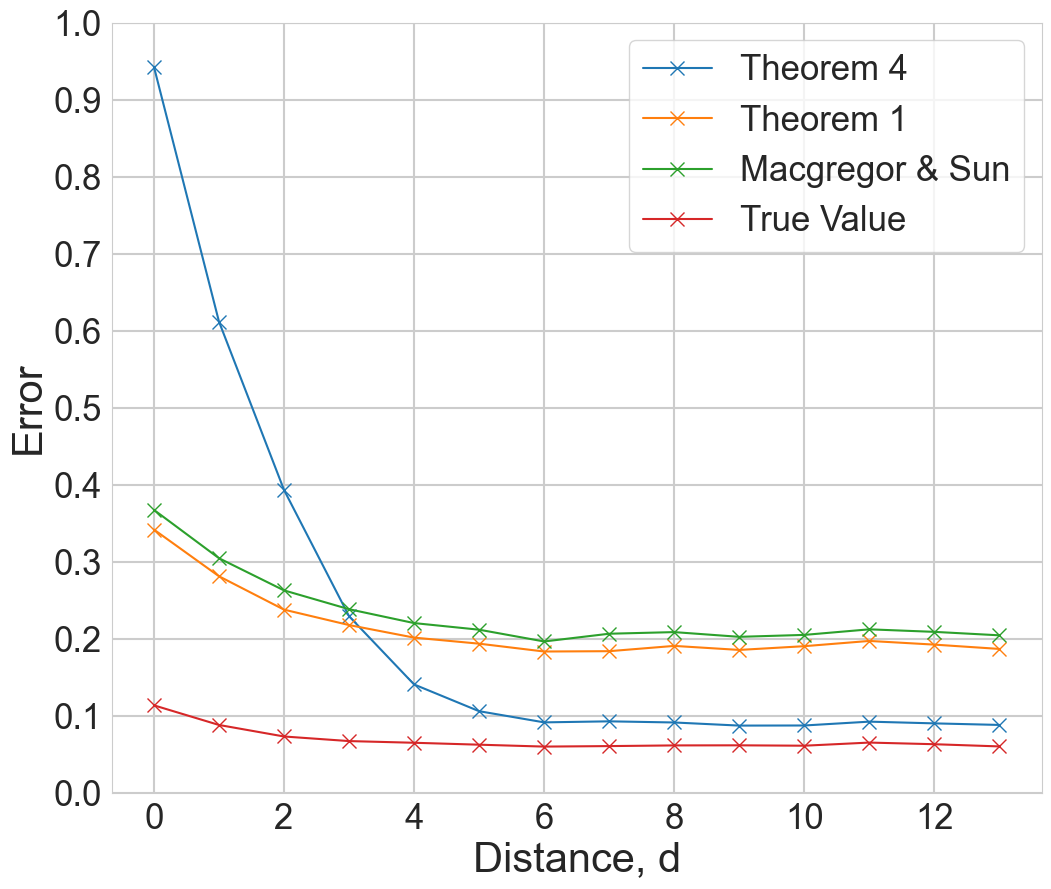

In [78]:
#bounds_df = pd.DataFrame([rst_bounds, st_bounds, k_way_bounds, true_values]).T
#bounds_df.columns = ["Theorem 4", "Theorem 1", "Macgregor & Sun", "True Value"]
#bounds_df.to_csv("Review-Data/4GeometricClusters2PairsDriftingApart.csv")

bounds_df = pd.read_csv("Review-Data/4GeometricClusters2PairsDriftingApart.csv", usecols=lambda column: column != "Unnamed: 0")

fig = plt.figure()
(bounds_df / 4).plot(marker='x', markersize=10, figsize=(12, 10))

#plt.legend(bbox_to_anchor=(1,1.05))
plt.xlabel("Distance, d", fontsize=30)
plt.ylabel("Error", fontsize=30)
plt.legend(fontsize=25)
plt.grid(visible=True, which='both', linewidth=1.5)
plt.xticks(fontsize=25)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=25)
# plt.title(
#     r"Bounds for $\frac{1}{4}\sum_{i=1}^4\|f_i - \hat{g}_i\|^2$ generated from Gaussian mixture model (4 clusters, 2 pairs)" + "\n Distance between pairs of clusters increased",
#     y=1.03)
plt.savefig("Review-Data/BoundsGaussianMixtureModel2PairsDriftingApart.png")

# TESTING ERRORS FOR STOCHASTIC BLOCK MODELS
Our initial choice is an SBM with 4 clusters and where two pairs have a high affinity for each other. We use 
$$
P = \begin{pmatrix}
    0.5 & 0.4 & 0.1 & 0.1 \\
    0.4 & 0.5 & 0.1 & 0.1 \\
    0.1 & 0.1 & 0.5 & 0.4 \\
    0.1 & 0.1 & 0.4 & 0.5 \\
    \end{pmatrix}
$$

In [44]:
P = np.array([[0.5, 0.4, 0.1, 0.1],
              [0.4, 0.5, 0.1, 0.1],
              [0.1, 0.1, 0.5, 0.4],
              [0.1, 0.1, 0.4, 0.5]])
K = 4

In [45]:
bounds = {}
sample_size = 10
for n in [200,300,400,500,600,700,800,900]:
    bounds[n] = 0
    for _ in range(sample_size):
        edges = []
        for i in range(K):
            for j in range(i,K):
                prob_existing_edge = P[i,j]
                if i == j:
                    for u in range(n):
                        for v in range(u+1,n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))
                                
                else:
                    for u in range(n):
                        for v in range(n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))
        
        true_clusters = [list(range(i*n, (i+1)*n)) for i in range(K)]                        
        G = Graph(vertices = list(range(n * K)), edges = edges)
        bounds[n] = bounds[n] + pd.Series(compute_all_bounds(G, K, [1,2,4], true_clusters = true_clusters))
    bounds[n] = bounds[n] / sample_size

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

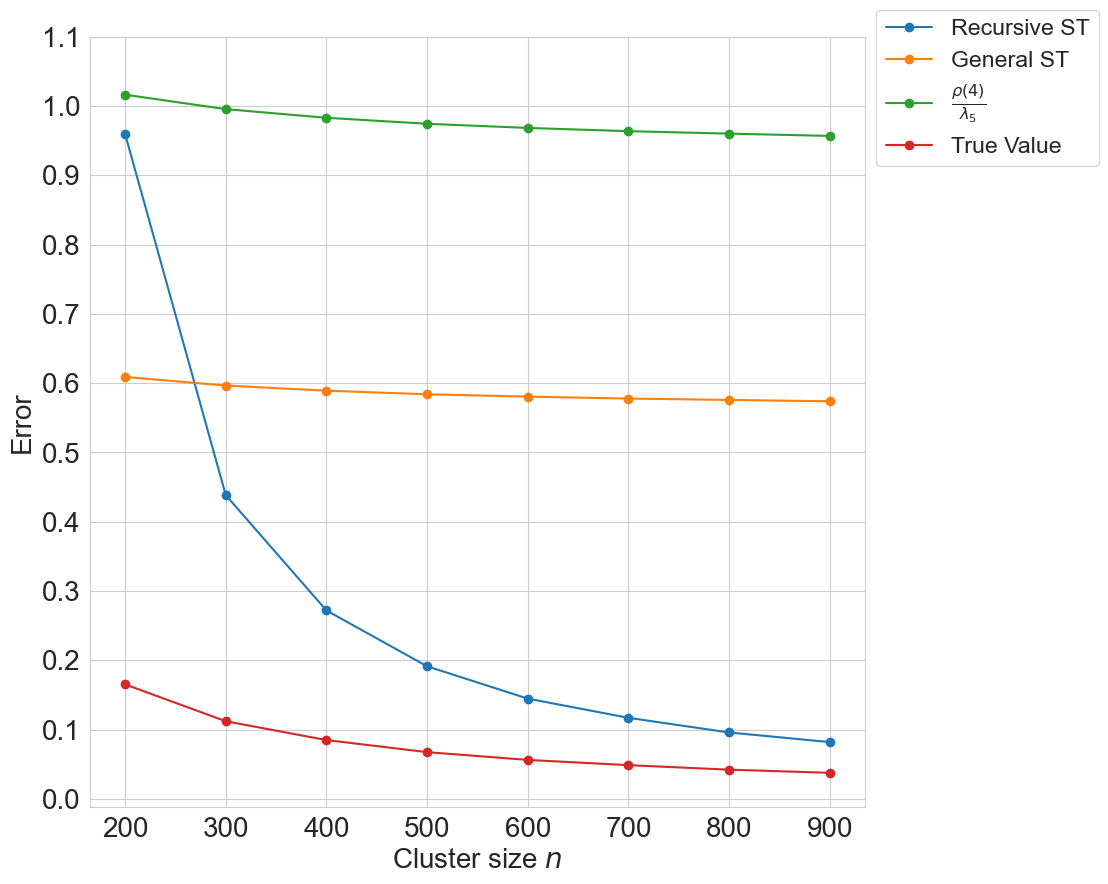

In [50]:
df = pd.DataFrame(bounds).T
columns = ['Recursive ST', 'General ST', r'$\frac{\rho(4)}{\lambda_5}$', 'True Value']
df.columns = columns
#df = df.drop(columns = ['General ST'])
df.to_csv('Review-Data/Bounds4Clusters2PairsRST.csv')

df = pd.read_csv("Review-Data/Bounds4Clusters2PairsRST.csv")
df = df.set_index("Unnamed: 0")

(df.loc[200:, :] / 4).plot(marker='o', xlabel='n', ylabel='Bound Value', figsize=(10, 10))
# plt.title(r'Bounds of $\frac{1}{4}\sum_{i=1}^4\|f_i - \hat{g}_i\|^2$ for SBM with four clusters in two pairs', y=1.03)
plt.xlabel(r'Cluster size $n$')
plt.ylabel(r'Error')
plt.grid(True)
# add ticks
plt.xticks(np.arange(200, 1000, 100))
plt.yticks(np.arange(0, 1.2, 0.1))
# make legend larger
plt.legend(fontsize='small', bbox_to_anchor=(1.0, 1.05))
plt.savefig('Review-Data/Bounds4Clusters2PairsRST.png', bbox_inches='tight')

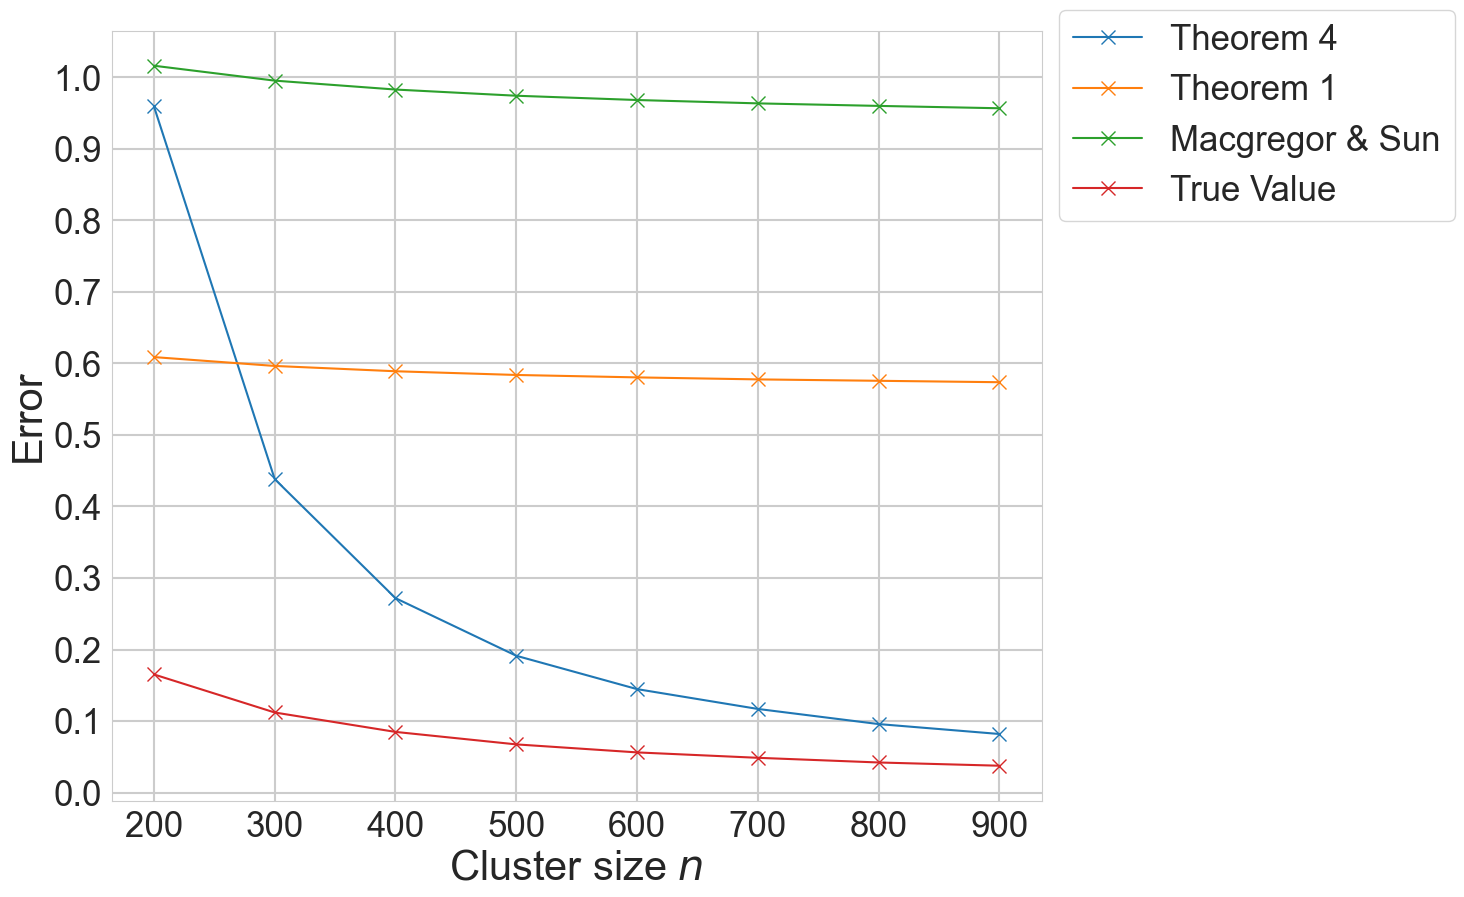

In [82]:
df_copy = pd.read_csv("Review-Data/Bounds4Clusters2PairsRST.csv")
df_copy = df_copy.set_index(["Unnamed: 0"])
df_copy.columns = ["Theorem 4", "Theorem 1", "Macgregor & Sun", "True Value"]
(df_copy.loc[200:,:] / 4).plot(marker='x', markersize=10, xlabel = 'n', ylabel = 'Bound Value', figsize = (12,10))
# plt.title(r'Bounds of $\frac{1}{8}\sum_{i=1}^8\|f_i - \hat{g}_i\|^2$ for SBM with 8 clusters (with one pair)', y=1.03)
plt.xlabel(r'Cluster size $n$', fontsize=30)
plt.ylabel(r'Error',fontsize=30)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,1.2,0.1))
plt.xticks(fontsize=25)
plt.yticks(np.arange(0,1.1,0.1),fontsize=25)
plt.grid(visible=True, which='both', linewidth=1.5)
# make legend larger
plt.legend(fontsize=25, bbox_to_anchor = (1.0,1.05))
plt.savefig('Review-Data/Bounds4Clusters2PairsRST.png', bbox_inches = "tight")

Repeating the experiment for an SBM with 8 clusters with a single pair that have an affinity for each other.

In [ ]:
K = 8
p1 = 0.5
p2 = 0.3
q = 0.05
P = np.ones((8,8))
P = q*P
np.fill_diagonal(P,p1)
P[0,1] = p2
P[1,0] = p2

In [ ]:
bounds = {}
sample_size = 10
for n in [200,300,400,500,600,700,800,900]:
    bounds[n] = 0
    for _ in range(sample_size):
        edges = []
        for i in range(K):
            for j in range(i,K):
                prob_existing_edge = P[i,j]
                if i == j:
                    for u in range(n):
                        for v in range(u+1,n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))
                                
                else:
                    for u in range(n):
                        for v in range(n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))
        
        true_clusters = [list(range(i*n, (i+1)*n)) for i in range(K)]                        
        G = Graph(vertices = list(range(n * K)), edges = edges)
        bounds[n] = bounds[n] + pd.Series(compute_all_bounds(G, K, [1,2,7,8], true_clusters = true_clusters))
    bounds[n] = bounds[n] / sample_size

In [ ]:
# df = pd.DataFrame(bounds).T
# df = df.loc[200:900,:]
# columns = ['Recursive ST', 'General ST', r'$\frac{\rho(8)}{\lambda_9}$', 'True Value']
# df.columns = columns
# #df = df.drop(columns = ['General ST'])
# df.to_csv("Review-Data/Bounds8Clusters1PairRST.csv")

(df.loc[200:,:] / 8).plot(marker = 'o', xlabel = 'n', ylabel = 'Bound Value', figsize = (10,10))
# plt.title(r'Bounds of $\frac{1}{8}\sum_{i=1}^8\|f_i - \hat{g}_i\|^2$ for SBM with 8 clusters (with one pair)', y=1.03)
plt.xlabel(r'Cluster size $n$')
plt.ylabel(r'Bound Value')
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,1.2,0.1))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor = (1.0,1.05))
plt.savefig('Review-Data/Bounds8Clusters1PairRST.png', bbox_inches = "tight")

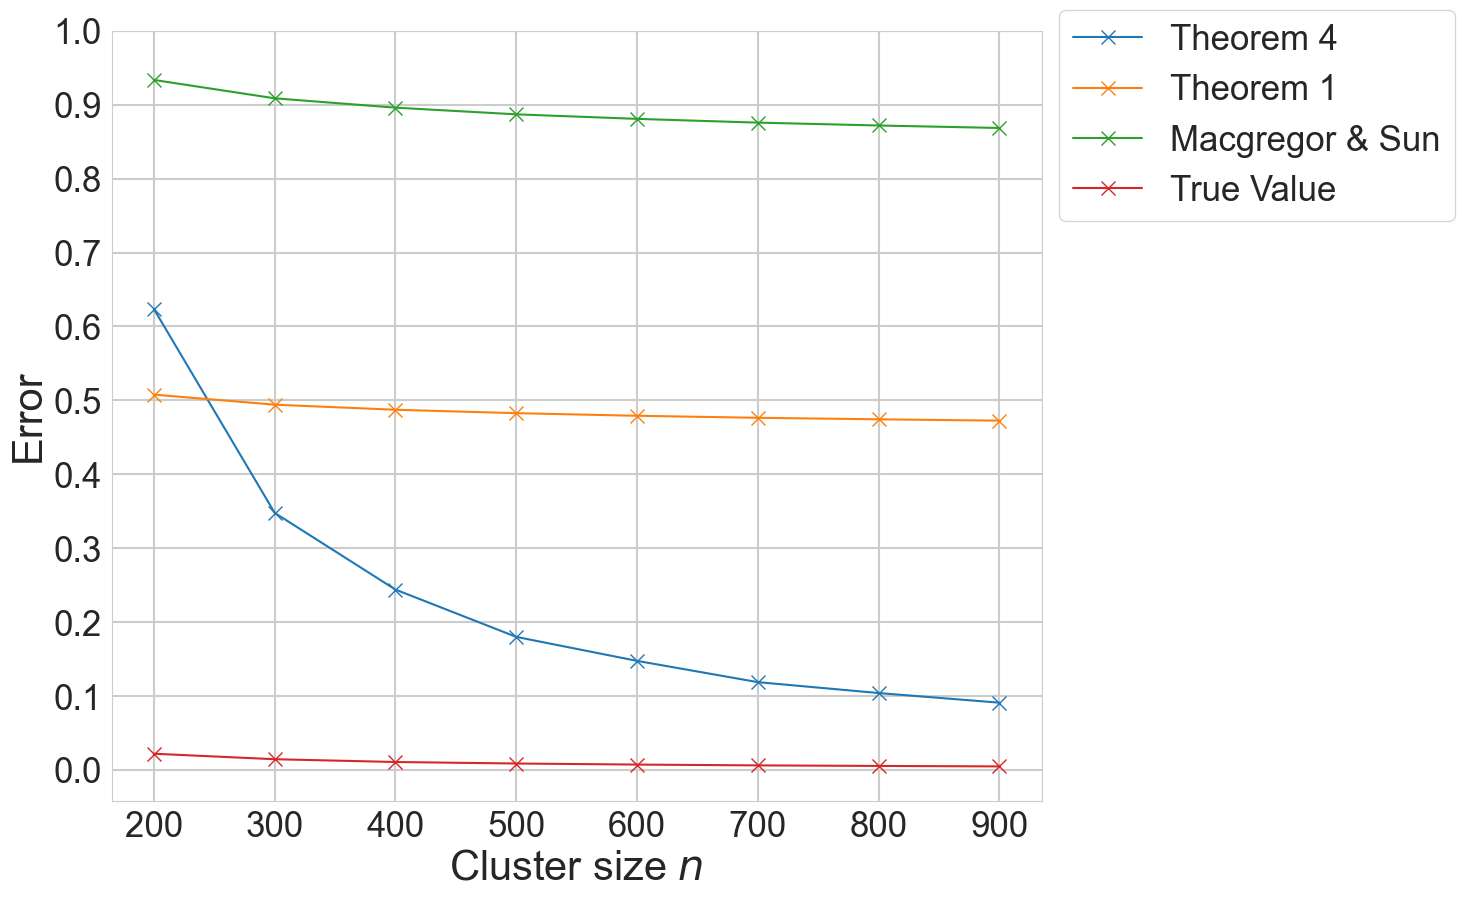

In [83]:
df_copy = pd.read_csv("Review-Data/Bounds8Clusters1PairRST.csv")
df_copy = df_copy.set_index(["Unnamed: 0"])
df_copy.columns = ["Theorem 4", "Theorem 1", "Macgregor & Sun", "True Value"]
(df_copy.loc[200:,:] / 8).plot(marker = 'x', markersize=10, xlabel = 'n', ylabel = 'Bound Value', figsize = (12,10))
# plt.title(r'Bounds of $\frac{1}{8}\sum_{i=1}^8\|f_i - \hat{g}_i\|^2$ for SBM with 8 clusters (with one pair)', y=1.03)
plt.xlabel(r'Cluster size $n$', fontsize = 30)
plt.ylabel(r'Error', fontsize = 30)
plt.grid(True, which='both', linewidth=1.5)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,1.2,0.1))
plt.xticks(fontsize=25)
plt.yticks(np.arange(0,1.1,0.1), fontsize=25)
# make legend larger
plt.legend(fontsize=25, bbox_to_anchor = (1.0,1.05))
plt.savefig('Review-Data/Bounds8Clusters1PairRST.png', bbox_inches = "tight")

In [ ]:
df_copy

## Varying n at the Threshold
we take an SBM with two clusters and P defined as
$$ P = \begin{pmatrix}
p & q \\
q & p \\
\end{pmatrix}$$
where $p = \frac{\alpha\log(N)}{N}$ and $q = \frac{\beta \log(N)}{N}$
and $\sqrt{\alpha} - \sqrt{\beta} \geq \sqrt{2}$

In this experiment we will fix the values of $\alpha, \beta$ at the threshold with $\beta = 20$.

In [ ]:
K = 2
b = 20
a = (np.sqrt(b) + np.sqrt(K))**2

def get_P(a,b,N):
    p = a * np.log(N) / N
    q = b * np.log(N) / N
    P = np.array([[p,q],[q,p]])
    return P

bounds = {}
sample_size = 10
for n in [200,300,400,500,600,700,800,900,1000]:
    N = K*n
    bounds[n] = 0
    P = get_P(a,b,N)
    for _ in range(sample_size):
        edges = []
        for i in range(K):
            for j in range(i,K):
                prob_existing_edge = P[i,j]
                if i == j:
                    for u in range(n):
                        for v in range(u+1,n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))
                                
                else:
                    for u in range(n):
                        for v in range(n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))
        
        true_clusters = [list(range(i*n, (i+1)*n)) for i in range(K)]                        
        G = Graph(vertices = list(range(n * K)), edges = edges)
        bounds[n] = bounds[n] + pd.Series(compute_all_bounds(G, K, [1,2], true_clusters = true_clusters))
    bounds[n] = bounds[n] / sample_size

In [ ]:
df = pd.DataFrame(bounds).T
columns = ['Corollary 5', 'General ST', r'$\frac{\rho(2)}{\lambda_3}$', 'True Value']
df.columns = columns
df.to_csv("Review-Data/ThresholdVaryingNBeta20.csv")
# df = df.drop(columns = ['General ST'])
(df.loc[200:,:] / 2).plot(marker = 'o', xlabel = 'n', ylabel = 'Error', figsize = (10,10))
# plt.title(r'Bounds of $\frac{1}{2}\sum_{i=1}^2\|f_i - \hat{g}_i\|^2$ for SBM with 2 clusters at threshold' + '\n' + r'$\beta = 20, \alpha = (\sqrt{2} + \sqrt{\beta})^2$', y=1.03)
plt.xlabel(r'Cluster size $n$')
plt.ylabel(r'Error')
plt.grid(True)
# add ticks
plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,0.2,0.01))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor = (1.0,1.05))
plt.savefig("Review-Data/ThresholdVaryingNBeta20.png", bbox_inches="tight")

In [ ]:
df = pd.DataFrame(bounds).T
columns = ['Recursive ST', 'General ST', r'$\frac{\rho(2)}{\lambda_3}$', 'True Value']
df.columns = columns
# df = df.drop(columns = ['General ST'])
(df.loc[200:,:] / 2).plot(marker = 'o', xlabel = 'n', ylabel = 'Bound Value', figsize = (10,10), logy = True)
# plt.title(r'Bounds of $\frac{1}{2}\sum_{i=1}^2\|f_i - \hat{g}_i\|^2$ for SBM with 2 clusters at threshold' + '\n' + r'$\beta = 20, \alpha = (\sqrt{2} + \sqrt{\beta})^2$', y=1.03)
plt.xlabel(r'Cluster size $n$')
plt.ylabel(r'Error')
plt.grid(True)
# add ticks
plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,0.2,0.01))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor = (1.0,1.05))
plt.savefig("Review-Data/ThresholdVaryingNBeta20LogScale.png", bbox_inches="tight")

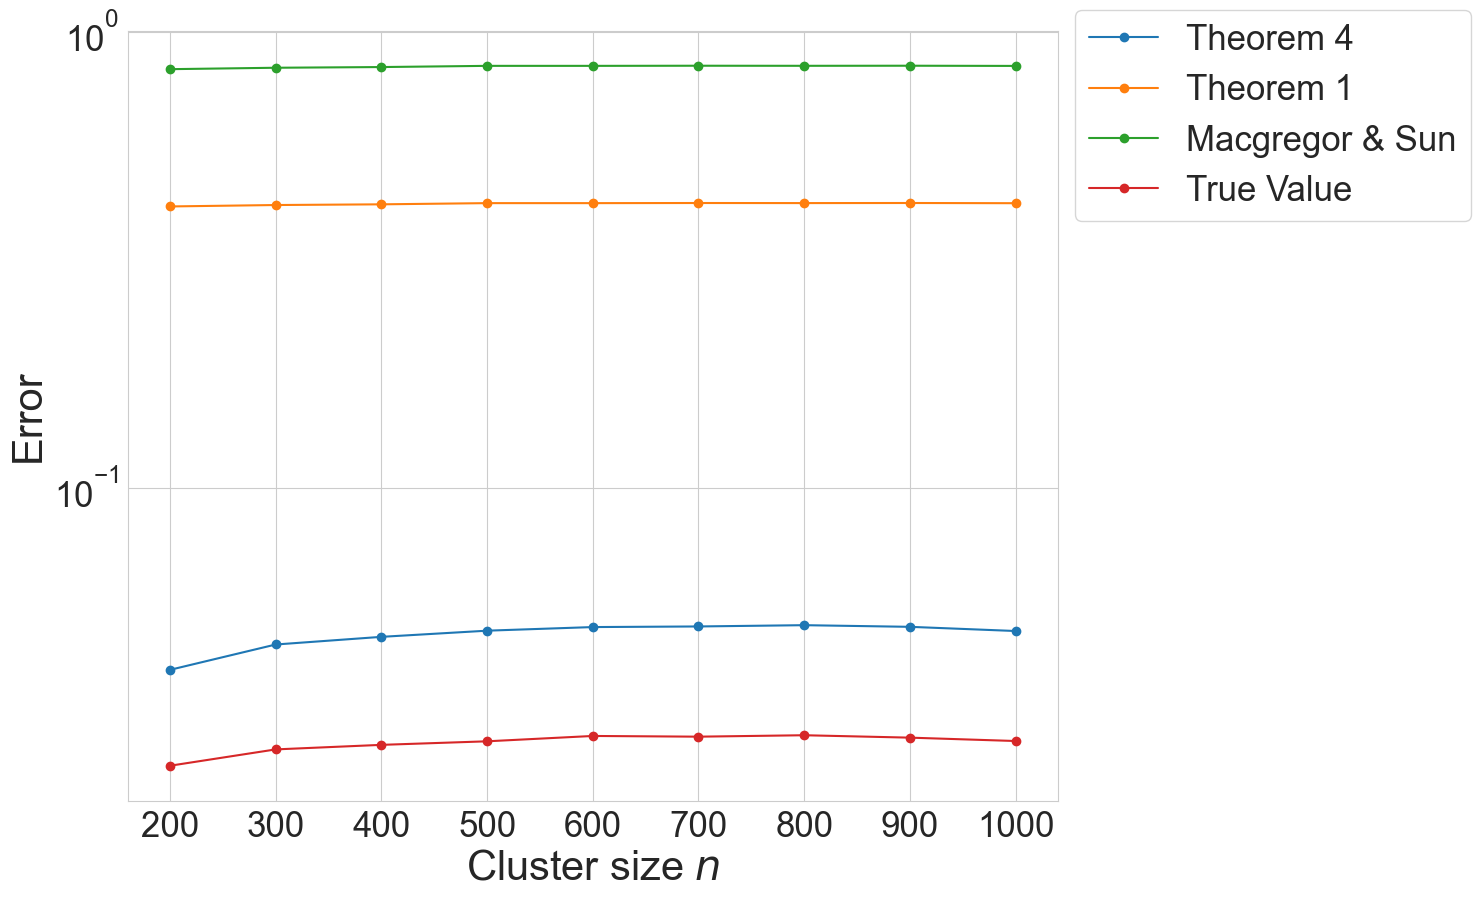

In [64]:
df_copy = pd.read_csv("Review-Data/ThresholdVaryingNBeta20.csv")
df_copy = df_copy.set_index(["Unnamed: 0"])
df_copy.columns = ["Theorem 4", "Theorem 1", "Macgregor & Sun", "True Value"]
(df_copy.loc[200:,:] / 2).plot(marker = 'o', xlabel = 'n', ylabel = 'Bound Value', figsize = (12,10), logy=True)
# plt.title(r'Bounds of $\frac{1}{8}\sum_{i=1}^8\|f_i - \hat{g}_i\|^2$ for SBM with 8 clusters (with one pair)', y=1.03)
plt.xlabel(r'Cluster size $n$', fontsize = 30)
plt.ylabel(r'Error', fontsize = 30)
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,1.2,0.1))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# make legend larger
plt.legend(fontsize=25, bbox_to_anchor = (1.0,1.05))
plt.savefig('Review-Data/ThresholdVaryingNBeta20LogScale.png', bbox_inches = "tight")

In [ ]:
K = 2
b = 1
a = (np.sqrt(b) + np.sqrt(K)) ** 2


def get_P(a,b,N):
    p = a * np.log(N) / N
    q = b * np.log(N) / N
    P = np.array([[p,q],[q,p]])
    return P


bounds = {}
sample_size = 10
for n in [200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    N = K*n
    bounds[n] = 0
    P = get_P(a, b, N)
    for _ in range(sample_size):
        edges = []
        for i in range(K):
            for j in range(i, K):
                prob_existing_edge = P[i, j]
                if i == j:
                    for u in range(n):
                        for v in range(u + 1, n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))

                else:
                    for u in range(n):
                        for v in range(n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))

        true_clusters = [list(range(i * n, (i + 1) * n)) for i in range(K)]
        G = Graph(vertices=list(range(n * K)), edges=edges)
        bounds[n] = bounds[n] + pd.Series(compute_all_bounds(G, K, [1, 2], true_clusters=true_clusters))
    bounds[n] = bounds[n] / sample_size

In [ ]:
df = pd.DataFrame(bounds).T
columns = ['Corollary 5', 'General ST', r'$\frac{\rho(2)}{\lambda_3}$', 'True Value']
df.columns = columns
df.to_csv("Review-Data/ThresholdVaryingNBeta1.csv")
#df = df.drop(columns=['General ST'])
(df.loc[200:, :] / 2).plot(marker='o', xlabel='n', ylabel='Bound Value', figsize=(10, 10))
# plt.title(r'Bounds of $\frac{1}{2}\sum_{i=1}^2\|f_i - \hat{g}_i\|^2$ for SBM with 2 clusters at threshold' + '\n' + r'$\beta = 20, \alpha = (\sqrt{2} + \sqrt{\beta})^2$', y=1.03)
plt.xlabel(r'Cluster size $n$')
plt.ylabel(r'Error')
plt.grid(True)
# add ticks
plt.xticks(np.arange(200, 1000, 100))
#plt.yticks(np.arange(0,0.2,0.01))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor=(1.0, 1.05))
plt.savefig("ThresholdVaryingNBeta1.png", bbox_inches="tight")

In [ ]:
df = pd.DataFrame(bounds).T
columns = ['Corollary 5', 'General ST', r'$\frac{\rho(2)}{\lambda_3}$', 'True Value']
df.columns = columns
#df = df.drop(columns=['General ST'])

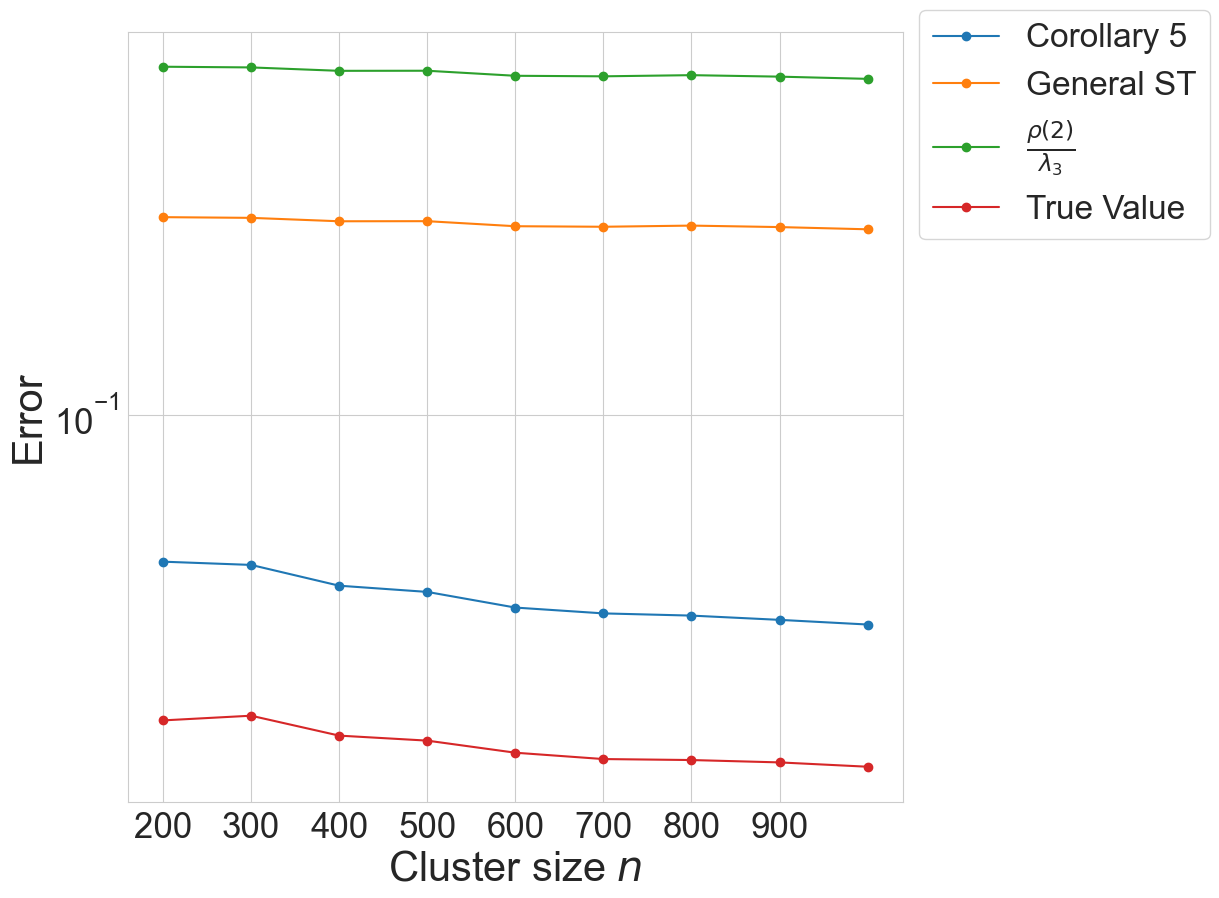

In [65]:

df = pd.read_csv("Review-Data/ThresholdVaryingNBeta1.csv")
df = df.set_index(["Unnamed: 0"])
(df.loc[200:, :] / 2).plot(marker='o', xlabel='n', ylabel='Bound Value', figsize=(10, 10), logy=True)
# plt.title(r'Bounds of $\frac{1}{2}\sum_{i=1}^2\|f_i - \hat{g}_i\|^2$ for SBM with 2 clusters at threshold' + '\n' + r'$\beta = 20, \alpha = (\sqrt{2} + \sqrt{\beta})^2$', y=1.03)
plt.xlabel(r'Cluster size $n$',fontsize=30)
plt.ylabel(r'Error',fontsize=30)
plt.grid(True)
# add ticks
plt.xticks(np.arange(200, 1000, 100), fontsize=25)

plt.yticks(fontsize=25)
# make legend larger
plt.legend(fontsize=25, bbox_to_anchor = (1.0,1.05))
#plt.yticks(np.arange(0,0.2,0.01))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor=(1.0, 1.05))
plt.savefig("Review-Data/ThresholdVaryingNBeta1LogScale.png")

Repeating the same experiment but varying $\beta$ with n fixed. We fix n = 500 and vary $\beta$ from 1 to 20. We set $\alpha = (\sqrt{\beta} + \sqrt{2})^2$

In [ ]:
K = 2

def get_P(b,N):
    a = (np.sqrt(b) + np.sqrt(K))**2
    p = a * np.log(N) / N
    q = b * np.log(N) / N
    P = np.array([[p,q],[q,p]])
    return P

bounds = {}
sample_size = 1
n = 500
for b in range(5,20):
    bounds[b] = 0
    N = K*n
    P = get_P(b,N)
    for _ in range(sample_size):
        edges = []
        for i in range(K):
            for j in range(i,K):
                prob_existing_edge = P[i,j]
                if i == j:
                    for u in range(n):
                        for v in range(u+1,n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))
                                
                else:
                    for u in range(n):
                        for v in range(n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))
        
        true_clusters = [list(range(i*n, (i+1)*n)) for i in range(K)]                        
        G = Graph(vertices = list(range(n * K)), edges = edges)
        bounds[b] = bounds[b] + pd.Series(compute_all_bounds(G, K, [1,2], true_clusters = true_clusters))
    bounds[b] = bounds[b] / sample_size

In [ ]:
df = pd.DataFrame(bounds).T
columns = ['Corollary 5', 'General ST', r'$\frac{\rho(2)}{\lambda_3}$', 'True Value']
df.columns = columns
# df = df.drop(columns = ['General ST'])
df.to_csv("Review-Data/ThresholdVaryingBetaAtThreshold.csv")
(df.loc[1:,:] / 2).plot(marker = 'o', xlabel = 'n', ylabel = 'Bound Value', figsize = (10,10))
# plt.title(r'Bounds of $\frac{1}{2}\sum_{i=1}^2\|f_i - \hat{g}_i\|^2$ for SBM with 2 clusters at threshold' + '\n' + r' varying $\beta$, $\alpha = (\sqrt{2} + \sqrt{\beta})^2$, cluster size $n=500$', y=1.03)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Error')
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,0.2,0.01))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor = (1.0,1.05))
plt.savefig("Review-Data/ThresholdVaryingBetaAtThreshold.png", bbox_inches="tight")

In [ ]:
df = pd.DataFrame(bounds).T
columns = ['Corollary 5', 'General ST', r'$\frac{\rho(2)}{\lambda_3}$', 'True Value']
df.columns = columns
# df = df.drop(columns = ['General ST'])
(df.loc[1:,:] / 2).plot(marker = 'o', xlabel = 'n', ylabel = 'Bound Value', figsize = (10,10), logy=True)
# plt.title(r'Bounds of $\frac{1}{2}\sum_{i=1}^2\|f_i - \hat{g}_i\|^2$ for SBM with 2 clusters at threshold' + '\n' + r' varying $\beta$, $\alpha = (\sqrt{2} + \sqrt{\beta})^2$, cluster size $n=500$', y=1.03)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Error')
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,0.2,0.01))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor = (1.0,1.05))
plt.savefig("Review-Data/ThresholdVaryingBetaAtThresholdLogScale.png", bbox_inches="tight")

In [ ]:
df_copy = pd.read_csv("Review-Data/ThresholdVaryingBetaAtThreshold.csv")
df_copy = df_copy.set_index(["Unnamed: 0"])
df_copy.columns = ["Theorem 4", "Theorem 1", "Macgregor & Sun", "True Value"]
(df_copy.loc[1:,:] / 2).plot(marker = 'o', xlabel = 'n', ylabel = 'Bound Value', figsize = (12,10), logy=True)
# plt.title(r'Bounds of $\frac{1}{8}\sum_{i=1}^8\|f_i - \hat{g}_i\|^2$ for SBM with 8 clusters (with one pair)', y=1.03)
plt.xlabel(r'$\beta$', fontsize = 20)
plt.ylabel(r'Error', fontsize = 20)
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,1.2,0.1))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor = (1.0,1.05))
plt.savefig('Review-Data/ThresholdVaryingBetaAtThresholdLogScale.png', bbox_inches = "tight")

Now we consider fixing larger $\alpha$ and increasing $\beta$

In [ ]:
K = 2
max_b = 20
a = 35

def get_P(b, n):
    
    p = a * np.log(n) / n
    q = b * np.log(n) / n
    P = np.array([[p, q], [q, p]])
    return P


bounds = {}
sample_size = 10
n = 500

for b in range(10, max_b + 10):
    bounds[b] = 0
    P = get_P(b, n)
    for _ in range(sample_size):
        edges = []
        for i in range(K):
            for j in range(i, K):
                prob_existing_edge = P[i, j]
                if i == j:
                    for u in range(n):
                        for v in range(u + 1, n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))

                else:
                    for u in range(n):
                        for v in range(n):
                            if np.random.rand() <= prob_existing_edge:
                                edges.append((i * n + u, j * n + v))

        true_clusters = [list(range(i * n, (i + 1) * n)) for i in range(K)]
        G = Graph(vertices=list(range(n * K)), edges=edges)
        bounds[b] = bounds[b] + pd.Series(compute_all_bounds(G, K, [1, 2], true_clusters=true_clusters))
    bounds[b] = bounds[b] / sample_size
    


In [ ]:
    
df = pd.DataFrame(bounds).T
columns = ['Corollary 5', 'General ST', r'$\frac{\rho(2)}{\lambda_3}$', 'True Value']
df.columns = columns
#df = df.drop(columns=['General ST'])
df.to_csv("Review-Data/ThresholdVaryingBetaFixedAlpha.csv")
(df.loc[1:, :] / 2).plot(marker='o', xlabel='n', ylabel='Bound Value', figsize=(10, 10))
#plt.title(
 #   r'Bounds of $\frac{1}{2}\sum_{i=1}^2\|f_i - \hat{g}_i\|^2$ for SBM with 2 clusters at threshold' + '\n' + r' varying $\beta$, $\alpha = (\sqrt{2} + \sqrt{20})^2$, cluster size $n=500$',
 #   y=1.03)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Error')
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,0.2,0.01))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor=(1.0, 1.05))
plt.savefig("Review-Data/ThresholdVaryingBetaFixedAlpha.png", bbox_inches="tight")

In [ ]:
df = pd.DataFrame(bounds).T
columns = ['Corollary 5', 'General ST', r'$\frac{\rho(2)}{\lambda_3}$', 'True Value']
df.columns = columns
# df = df.drop(columns=['General ST'])
df.to_csv("Review-Data/ThresholdVaryingBetaFixedAlpha.csv")
(df.loc[1:, :] / 2).plot(marker='o', xlabel='n', ylabel='Bound Value', figsize=(10, 10), logy=True)
#plt.title(
 #   r'Bounds of $\frac{1}{2}\sum_{i=1}^2\|f_i - \hat{g}_i\|^2$ for SBM with 2 clusters at threshold' + '\n' + r' varying $\beta$, $\alpha = (\sqrt{2} + \sqrt{20})^2$, cluster size $n=500$',
 #   y=1.03)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Error')
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,0.2,0.01))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor=(1.0, 1.05))
plt.savefig("Review-Data/ThresholdVaryingBetaFixedAlphaLogScale.png", bbox_inches="tight")

In [ ]:
df_copy = pd.read_csv("Review-Data/ThresholdVaryingBetaFixedAlpha.csv")
df_copy = df_copy.set_index(["Unnamed: 0"])
df_copy.columns = ["Theorem 4", "Theorem 1", "Macgregor & Sun", "True Value"]
(df_copy.loc[1:,:] / 2).plot(marker = 'o', xlabel = 'n', ylabel = 'Bound Value', figsize = (12,10), logy=True)
# plt.title(r'Bounds of $\frac{1}{8}\sum_{i=1}^8\|f_i - \hat{g}_i\|^2$ for SBM with 8 clusters (with one pair)', y=1.03)
plt.xlabel(r'$\beta$', fontsize = 20)
plt.ylabel(r'Error', fontsize = 20)
plt.grid(True)
# add ticks
#plt.xticks(np.arange(200,1000,100))
#plt.yticks(np.arange(0,1.2,0.1))
# make legend larger
plt.legend(fontsize='large', bbox_to_anchor = (1.0,1.05))
plt.savefig('Review-Data/ThresholdVaryingBetaFixedAlphaLogScale.png', bbox_inches = "tight")

# Real-World Graphs

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (_, _) = mnist.load_data()

# Preprocess the data: Flatten the images to 1D arrays
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2]
samples_per_digit = 200
selected_samples = []
selected_labels = []

for digit in digits:
    indices = np.where(y_train == digit)[0][:samples_per_digit]
    selected_samples.append(x_train[indices])
    selected_labels.extend(y_train[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples)
selected_labels = np.array(selected_labels)

# Calculate the Pearson correlation matrix
correlation_matrix = np.corrcoef(selected_samples)

# Create a graph using the correlation matrix
threshold = 0.8  # Define a threshold for edge creation
G = nx.Graph()

# Add nodes with their corresponding digit label
for i, label in enumerate(selected_labels):
    G.add_node(i, label=int(label))

# Add edges for high correlations
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[0]):
        if correlation_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=correlation_matrix[i, j])

# Visualize the graph
plt.figure(figsize=(12, 8))

# Assign colors based on digit labels
colors = ["red" if selected_labels[node] == 0 else "blue" if selected_labels[node] == 1 else "green" for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G)  # Use a spring layout for visualization
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.7)
plt.title("Graph of MNIST Samples by Correlation")
plt.show()


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load the MNIST dataset using OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2]
samples_per_digit = 200
selected_samples = []
selected_labels = []

for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples) / 255.0  # Normalize pixel values
selected_labels = np.array(selected_labels)

# Calculate the Pearson correlation matrix
correlation_matrix = np.corrcoef(selected_samples)

# Create a graph using the correlation matrix
threshold = 0.7  # Define a threshold for edge creation
G = nx.Graph()

# Add nodes with their corresponding digit label
for i, label in enumerate(selected_labels):
    G.add_node(i, label=int(label))

# Add edges for high correlations
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[0]):
        if correlation_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=correlation_matrix[i, j])

# Remove disconnected components (keep the largest connected component)
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# Visualize the graph
plt.figure(figsize=(12, 8))

# Assign colors based on digit labels
colors = ["red" if G.nodes[node]['label'] == 0 else
          "blue" if G.nodes[node]['label'] == 1 else
          "green" for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G)  # Use a spring layout for visualization
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.7)
plt.title("Graph of MNIST Samples by Correlation (Largest Connected Component)")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the adjacency matrix of the graph
adjacency_matrix = nx.adjacency_matrix(G).todense()

# Plot the adjacency matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.array(adjacency_matrix), cmap='viridis', square=True, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()


In [ ]:
normalized_laplacian = nx.normalized_laplacian_matrix(G).todense()
# Compute the eigenvalues and eigenvectors of the normalized Laplacian
eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)

# Print the eigenvalues
print("Eigenvalues of the Normalized Laplacian:")
print(eigenvalues)


In [ ]:
sns.scatterplot(x= np.arange(5),y=eigenvalues[:5])

In [ ]:
# compute first K eigenvectors of the normalized Laplacian
K=3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

In [ ]:
rayleigh_quotients

In [ ]:
sns.scatterplot(normalized_L_eigenvalues[0:5])
sns.scatterplot(rayleigh_quotients)

In [ ]:
B_1 = (rayleigh_quotients[0]+rayleigh_quotients[1])/(normalized_L_eigenvalues[2])
B_2 = (rayleigh_quotients[2] - normalized_L_eigenvalues[2] + normalized_L_eigenvalues[3]*B_1)/(normalized_L_eigenvalues[3] - normalized_L_eigenvalues[2])

In [ ]:
B_1 + B_2

In [ ]:
B_1 = rayleigh_quotients[0]/normalized_L_eigenvalues[1]
B_2 = ((rayleigh_quotients[1] - normalized_L_eigenvalues[1]) + normalized_L_eigenvalues[2]*B_1)/(normalized_L_eigenvalues[2] - normalized_L_eigenvalues[1])
B_3 = ((rayleigh_quotients[2] - normalized_L_eigenvalues[2]) + normalized_L_eigenvalues[3]*(B_1+B_2))/(normalized_L_eigenvalues[3] - normalized_L_eigenvalues[2])

In [ ]:
(B_1 + B_2 + B_3)/3

In [ ]:
(np.sum(rayleigh_quotients)/normalized_L_eigenvalues[3])/3

In [ ]:
max(rayleigh_quotients)/normalized_L_eigenvalues[3]

In [ ]:
pd.DataFrame(adjacency_matrix).to_csv("Review-Data/MNIST_adjacency_matrix.csv")

In [ ]:
from collections import Counter

# Extract the labels of nodes in the largest connected component
remaining_labels = [G.nodes[node]['label'] for node in G.nodes()]

# Count the occurrences of each digit
digit_counts = Counter(remaining_labels)

# Print the counts
print("Counts of each digit in the largest connected component:")
print(digit_counts)

In [ ]:
import numpy as np

# Assuming remaining_labels is already populated with the labels of the nodes in the largest connected component
# For example:
# remaining_labels = [0, 1, 1, 2, 0, 2, 1, 0, ...]

# Convert remaining labels to numpy array for easier manipulation
remaining_labels = np.array(remaining_labels)

# Number of clusters (in this case, 3)
num_clusters = 3

# Initialize the indicator vectors (one per cluster)
indicator_vectors = np.zeros((num_clusters, len(remaining_labels)))

# Assign each node in remaining_labels to the appropriate indicator vector
for i, label in enumerate(remaining_labels):
    if label < num_clusters:
        indicator_vectors[label, i] = 1

# Print the indicator vectors
for i, vec in enumerate(indicator_vectors):
    print(f"Indicator vector for cluster {i}: {vec}")


In [ ]:
ind_vecs_transposed = indicator_vectors.T

In [ ]:
ind_vecs_transposed

In [ ]:
for i in range(3):
    ind_vecs_transposed[:,i] = D_sqrt @ ind_vecs_transposed[:,i]
    ind_vecs_transposed[:,i] = ind_vecs_transposed[:,i]/ np.linalg.norm(ind_vecs_transposed[:,i])

In [ ]:
true_val_matrix_combined = normalized_L_eigenvectors[:,:3] - ind_vecs_transposed @ (ind_vecs_transposed.T @ normalized_L_eigenvectors[:,:3]) 
# true val is frobenius norm of the matrix
true_val_combined = np.linalg.norm(true_val_matrix_combined)**2

In [ ]:
true_val_combined/3

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(normalized_L_eigenvectors[:,:3])
kmeans.labels_

In [ ]:
predicted_labels = kmeans.labels_
misclassified_vertices = []
# Step 3: Measure how many were misclassified
# We will compare the predicted cluster labels to the true labels
misclassifications = 0
for i in range(num_clusters):
    # Get the indices of the points that belong to cluster i
    cluster_indices = np.where(predicted_labels == i)[0]
    
    # Get the majority label in the current cluster
    cluster_true_labels = remaining_labels[cluster_indices]
    majority_label = np.bincount(cluster_true_labels).argmax()
    
    # Count how many points in this cluster were misclassified
    misclassified_vertices.append(cluster_true_labels != majority_label)
    
    misclassified_points_sum = np.sum(cluster_true_labels != majority_label)
    misclassifications += misclassified_points_sum

# Step 4: Print the number of misclassified points
print(f"Number of misclassified points: {misclassifications}")

In [ ]:
misclassified_vertices

In [ ]:
import numpy as np

# Assuming you have `remaining_labels` (true labels) and `predicted_labels` from K-means
# G is the graph (networkx Graph object)

# Step 1: Identify misclassified vertices
misclassified_vertices = np.where(remaining_labels != predicted_labels)[0]

# Step 2: Compute the volume of the misclassified vertices
volume = 0
for vertex in misclassified_vertices:
    volume += G.degree(vertex)

# Step 3: Print the volume of the misclassified vertices
print(f"Volume of the misclassified vertices: {volume}")


In [ ]:
misclassified_vertices

In [ ]:
import numpy as np
from sklearn.cluster import KMeans


# Step 1: Create a boolean vector for misclassifications
misclassified_vector = np.zeros(len(remaining_labels), dtype=bool)

# Step 2: Find the majority label for each cluster
for cluster_id in range(3):  # For each cluster
    # Get the indices of the nodes assigned to this cluster
    cluster_indices = np.where(predicted_labels == cluster_id)[0]
    
    # Get the true labels of the nodes in this cluster
    cluster_true_labels = remaining_labels[cluster_indices]
    
    # Find the majority true label for the nodes in this cluster
    majority_label = np.bincount(cluster_true_labels).argmax()
    
    # Step 3: Mark misclassified nodes in the boolean vector
    for idx in cluster_indices:
        if remaining_labels[idx] != majority_label:
            misclassified_vector[idx] = True

# Step 4: Print the misclassified vector and count misclassifications
print("Misclassified vector:", misclassified_vector)
print(f"Number of misclassified points: {np.sum(misclassified_vector)}")


In [ ]:
(D_sqrt @ misclassified_vector).T @ adjacency_matrix @ D_sqrt @ misclassified_vector

In [ ]:
misclassified_vector

In [ ]:
volume = 0
nodes = list(G.nodes)
for vertex in range(len(misclassified_vector)):
    if misclassified_vector[vertex]:
        volume += G.degree(nodes[vertex])
    

In [ ]:
volume

In [ ]:
degrees = [G.degree(n) for n in nodes]
np.mean(degrees)

# Fashion MNIST

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load the MNIST dataset using OpenML
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2]
samples_per_digit = 200
selected_samples = []
selected_labels = []

for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples) / 255.0  # Normalize pixel values
selected_labels = np.array(selected_labels)

# Calculate the Pearson correlation matrix
correlation_matrix = np.corrcoef(selected_samples)

# Create a graph using the correlation matrix
threshold = 0.7  # Define a threshold for edge creation
G = nx.Graph()

# Add nodes with their corresponding digit label
for i, label in enumerate(selected_labels):
    G.add_node(i, label=int(label))

# Add edges for high correlations
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[0]):
        if correlation_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=correlation_matrix[i, j])

# Remove disconnected components (keep the largest connected component)
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# Visualize the graph
plt.figure(figsize=(12, 8))

# Assign colors based on digit labels
colors = ["red" if G.nodes[node]['label'] == 0 else
          "blue" if G.nodes[node]['label'] == 1 else
          "green" for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G)  # Use a spring layout for visualization
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.7)
plt.title("Graph of MNIST Samples by Correlation (Largest Connected Component)")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the adjacency matrix of the graph
adjacency_matrix = nx.adjacency_matrix(G).todense()

# Plot the adjacency matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.array(adjacency_matrix), cmap='viridis', square=True, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()

normalized_laplacian = nx.normalized_laplacian_matrix(G).todense()
# Compute the eigenvalues and eigenvectors of the normalized Laplacian
eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)

# Print the eigenvalues
print("Eigenvalues of the Normalized Laplacian:")
print(eigenvalues)

sns.scatterplot(x=np.arange(5), y=eigenvalues[:5])
# compute first K eigenvectors of the normalized Laplacian
K = 3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis=0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                     i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)
rayleigh_quotients
sns.scatterplot(normalized_L_eigenvalues[0:5])
sns.scatterplot(rayleigh_quotients)
B_1 = (rayleigh_quotients[0] + rayleigh_quotients[1]) / (normalized_L_eigenvalues[2])
B_2 = (rayleigh_quotients[2] - normalized_L_eigenvalues[2] + normalized_L_eigenvalues[3] * B_1) / (
            normalized_L_eigenvalues[3] - normalized_L_eigenvalues[2])
B_1 + B_2


In [ ]:
B_1 = rayleigh_quotients[0] / normalized_L_eigenvalues[1]
B_2 = ((rayleigh_quotients[1] - normalized_L_eigenvalues[1]) + normalized_L_eigenvalues[2] * B_1) / (
            normalized_L_eigenvalues[2] - normalized_L_eigenvalues[1])
B_3 = ((rayleigh_quotients[2] - normalized_L_eigenvalues[2]) + normalized_L_eigenvalues[3] * (B_1 + B_2)) / (
            normalized_L_eigenvalues[3] - normalized_L_eigenvalues[2])
(B_1 + B_2 + B_3) / 3

# IRIS

In [ ]:
def gaussian_kernel(X, sigma):
    pairwise_sq_dists = np.sum(X**2, axis=1)[:, np.newaxis] + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
    K = np.exp(-pairwise_sq_dists / (2 * sigma**2))
    return K

In [ ]:
from sklearn.metrics import pairwise_distances

def knn_adjacency_matrix(features, k, metric='euclidean'):
    if k <= 0:
        raise ValueError("k must be a positive integer.")

    # Compute the pairwise distances
    distances = pairwise_distances(features, metric=metric)

    # Get the indices of the k-nearest neighbors for each point
    knn_indices = np.argsort(distances, axis=1)[:, 1:k+1]

    # Initialize the adjacency matrix
    n_points = features.shape[0]
    adjacency_matrix = np.zeros((n_points, n_points), dtype=float)

    # Fill the adjacency matrix
    for i in range(n_points):
        for j in knn_indices[i]:
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1  # Ensure the graph is undirected

    return adjacency_matrix

In [ ]:
sns.heatmap(knn_adjacency_matrix(x_data,6))

In [ ]:
mnist = fetch_openml('iris', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target

targets = np.unique(y_data).tolist()

selected_samples = []
selected_labels = []

for target in targets:
    indices = np.where(y_data == target)[0]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

selected_samples = np.vstack(selected_samples)
selected_labels = np.array(selected_labels)
# Calculate the Pearson correlation matrix
correlation_matrix = knn_adjacency_matrix(x_data,6)

# Visualize the graph
plt.figure(figsize=(12, 8))
color_list = ["red","blue","green","yellow"]

colors = []
for node in G.nodes():
    target_ind = targets.index(G.nodes[node]['label'])
    colors.append(color_list[target_ind])
    
# Draw the graph
pos = nx.spring_layout(G)  # Use a spring layout for visualization
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.7)
plt.title("Graph of MNIST Samples by Correlation (Largest Connected Component)")
plt.show()

# Get the adjacency matrix of the graph
adjacency_matrix = correlation_matrix.copy()

# Plot the adjacency matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.array(adjacency_matrix), cmap='viridis', square=True, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()

degrees = np.sum(adjacency_matrix, axis = 1)
D_inv_sqrt = np.diag([1/np.sqrt(d) for d in degrees])
normalized_laplacian = np.eye(len(degrees)) - D_inv_sqrt @ adjacency_matrix @ D_inv_sqrt
# Compute the eigenvalues and eigenvectors of the normalized Laplacian
eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)

# Print the eigenvalues
print("Eigenvalues of the Normalized Laplacian:")
print(eigenvalues)

sns.scatterplot(x=np.arange(5), y=eigenvalues[:5])
# compute first K eigenvectors of the normalized Laplacian
K = 3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis=0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                     i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)
rayleigh_quotients
sns.scatterplot(normalized_L_eigenvalues[0:5])
sns.scatterplot(rayleigh_quotients)

In [ ]:
B_1 = (rayleigh_quotients[0] + rayleigh_quotients[1]) / (normalized_L_eigenvalues[2])
B_2 = (rayleigh_quotients[2] - normalized_L_eigenvalues[2] + normalized_L_eigenvalues[3] * B_1) / (
            normalized_L_eigenvalues[3] - normalized_L_eigenvalues[2])
B_1 + B_2

In [ ]:
(B_1 + B_2)/3

# HAR

In [ ]:
mnist = fetch_openml('har', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

In [ ]:
np.unique(y_data)

In [ ]:
digits = [1, 2, 3]
samples_per_digit = 200
selected_samples = []
selected_labels = []

for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples)
selected_labels = np.array(selected_labels)

# Calculate the Pearson correlation matrix
correlation_matrix = np.corrcoef(selected_samples)

# Create a graph using the correlation matrix
threshold = 0.9  # Define a threshold for edge creation
G = nx.Graph()

# Add nodes with their corresponding digit label
for i, label in enumerate(selected_labels):
    G.add_node(i, label=int(label))

# Add edges for high correlations
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[0]):
        if correlation_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=correlation_matrix[i, j])

# Remove disconnected components (keep the largest connected component)
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# Visualize the graph
plt.figure(figsize=(12, 8))

# Assign colors based on digit labels
colors = ["red" if G.nodes[node]['label'] == 0 else
          "blue" if G.nodes[node]['label'] == 1 else
          "green" for node in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G)  # Use a spring layout for visualization
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50, edge_color="gray", alpha=0.7)
plt.title("Graph of MNIST Samples by Correlation (Largest Connected Component)")
plt.show()


In [ ]:
# Get the adjacency matrix of the graph
adjacency_matrix = nx.adjacency_matrix(G).todense()

# Plot the adjacency matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.array(adjacency_matrix), cmap='viridis', square=True, cbar=True, xticklabels=False, yticklabels=False)
plt.title("Adjacency Matrix Heatmap")
plt.xlabel("Nodes")
plt.ylabel("Nodes")
plt.show()

normalized_laplacian = nx.normalized_laplacian_matrix(G).todense()
# Compute the eigenvalues and eigenvectors of the normalized Laplacian
eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)

# Print the eigenvalues
print("Eigenvalues of the Normalized Laplacian:")
print(eigenvalues)

sns.scatterplot(x=np.arange(5), y=eigenvalues[:5])
# compute first K eigenvectors of the normalized Laplacian
K = 3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis=0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                     i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)
rayleigh_quotients
sns.scatterplot(normalized_L_eigenvalues[0:5])
sns.scatterplot(rayleigh_quotients)
B_1 = (rayleigh_quotients[0] + rayleigh_quotients[1]) / (normalized_L_eigenvalues[2])
B_2 = (rayleigh_quotients[2] - normalized_L_eigenvalues[2] + normalized_L_eigenvalues[3] * B_1) / (
            normalized_L_eigenvalues[3] - normalized_L_eigenvalues[2])
B_1 + B_2
